# Genome Assembly and Assessment using Nextflow and AWS Batch

## Overview

This short tutorial demonstrates how to run a comparative genomics workflow using a bacteria data set. Steps in the workflow combine the analyses you performed in previous submodules, and include:
- Read QC and trimming (fastqc, fastp)
- Genome assembly (SPAdes)
- Contiguity assessment (QUAST)
- Completeness assessment (BUSCO)
- Coverage assessment (BWA & Samtools)
- Taxonomic assignment (BLAST)
- Combine datasets (Blobtools)
- Genome annotation (Bakta)

The tutorial uses a popular workflow manager called [Nextflow](https://www.nextflow.io) run via [AWS Batch](https://aws.amazon.com/batch/) to automate the processes run in Submodules 1 & 2.

AWS Batch will create the needed permissions, roles and resources to run Nextflow in a serverless manner. You can set up AWS Batch manually or deploy it **automatically** with a stack template. The Launch Stack button below will take you to the cloud formation create stack webpage with the template with required resources already linked. 

If you prefer to skip manual deployment and deploy automatically in the cloud, click the Launch Stack button below. For a walkthrough of the screens during automatic deployment please click [here](https://github.com/NIGMS/NIGMS-Sandbox/blob/main/docs/HowToLaunchAWSBatch.md). The deployment should take ~5 min and then the resources will be ready for use. 

[![Launch Stack](images/LaunchStack.jpg)](https://console.aws.amazon.com/cloudformation/home?#/stacks/new?stackName=aws-batch-nigms&templateURL=https://nigms-sandbox.s3.us-east-1.amazonaws.com/cf-templates/AWSBatch_template.yaml )

Before begining this tutorial, if you do not have required roles, policies, permissions or compute environment and would like to **manually** set those up please click [here](https://github.com/NIGMS/NIGMS-Sandbox/blob/main/docs/AWS-Batch-Setup.md) to set that up.


## Prerequisites
#### Python requirements
+ Python >= 3.8

#### AWS requirements
+ Please ensure you have a VPC, subnets, and security group set up before running this tutorial.
+ Role with AdministratorAccess, AmazonSageMakerFullAccess, S3 access and AWSBatchServiceRole.
+ Instance Role with AmazonECS_FullAccess, AmazonEC2ContainerRegistryFullAccess, and S3 access.
+ If you do not have the required set-up for AWS Batch please follow this tutorial [here](https://github.com/STRIDES/NIHCloudLabAWS/blob/main/notebooks/AWSBatch/Intro_AWS_Batch.ipynb). ***When making the instance role, make another for SageMaker notebooks with the following permissions: AdminstratorAccess, AmazonEC2ContainerRegistryFullAccess, AmazonECS_FullAccess, AmazonS3FullAccess, AmazonSageMakerFullAccess, and AWSBatchServiceRole.***
It is recommended that specific permission to folders are added through inline policy. An example of the JSON is below:

<pre>
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AllowSageMakerS3Access",
            "Effect": "Allow",
            "Action": [
                "s3:GetObject",
                "s3:PutObject",
                "s3:ListBucket",
                "s3:GetBucketLocation",
                "s3:CreateBucket"
            ],
            "Resource": [
                "arn:aws:s3:::batch-bucket",
                "arn:aws:s3:::batch-bucket/*",
                "arn:aws:s3:::nigms-sandbox-healthomics",
                "arn:aws:s3:::nigms-sandbox-healthomics/*",
                "arn:aws:s3:::ngi-igenomes",
                "arn:aws:s3:::ngi-igenomes/*"
            ]
        }
    ]
}
</pre>
For AWS bucket naming conventions, please click [here](https://docs.aws.amazon.com/AmazonS3/latest/userguide/bucketnamingrules.html).

### Step 1. Install required dependencies, update paths and create a new S3 Bucket to store input and output files (if needed)


In [1]:
import boto3
# Get account ID and region 
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name

In [24]:
# Set variable names 
# These variables should come from the Intro AWS Batch tutorial (or leave as-is if using the launch stack button)
BUCKET_NAME = "aws-batch-nigms-batch-bucket-" + account_id
INPUT_FOLDER = 'nigms-sandbox/unh-wgsbac-pipeline'
AWS_QUEUE = 'aws-batch-nigms-JobQueue'
AWS_REGION = region

In [25]:
#Make an s3 bucket to store input and output files
!aws s3 mb s3://$BUCKET_NAME

make_bucket: aws-batch-nigms-batch-bucket-009160061335


In [26]:
# replace batch bucket name in nextflow configuration file 
! sed -i "s/aws-batch-nigms-batch-bucket/$BUCKET_NAME/g" wgsbac/nextflow.config

In [27]:
# replace job queue name in configuration file 
! sed -i "s/aws-batch-nigms-JobQueue/$AWS_QUEUE/g" wgsbac/nextflow.config

In [28]:
# replace the region placeholder with your region
! sed -i "s/aws-region/$AWS_REGION/g" wgsbac/nextflow.config

### Step 2. Enable AWS Batch for the nextflow script 

In [2]:
# Run nextflow script with parameters 
! ./nextflow run wgsbac/main.nf \
  --input s3://$INPUT_FOLDER/samplesheet_test.csv \
  -profile docker,awsbatch \
  -c wgsbac/nextflow.config \
  --awsqueue $AWS_QUEUE \
  --awsregion $AWS_REGION 


 N E X T F L O W   ~  version 25.04.3

Launching `wgsbac/main.nf` [grave_torricelli] DSL2 - revision: a524a11e00

ERROR ~ The specified bucket does not exist (Service: Amazon S3; Status Code: 404; Error Code: NoSuchBucket; Request ID: CVQA83YFJAVCZ3JD; S3 Extended Request ID: QJ1RwCqocB2h65Y2CtkcfPfb004aLMLdTdv6CKabAebbWgkD+Cf1W11aMuqIWMkd7ZIpz663L2DsazYbNyrdmroGbu/J/UKV; Proxy: null)

 -- Check '.nextflow.log' file for details


### Step 3: Explore Results

In [6]:
# View output files that were output to S3 bucket
! aws s3 ls s3://$BUCKET_NAME/nextflow_output/final_reports/final_results/ --recursive | cut -c32-

nextflow_output/final_reports/final_results/
nextflow_output/final_reports/final_results/bakta_results/
nextflow_output/final_reports/final_results/bakta_results/proteomes/
nextflow_output/final_reports/final_results/bakta_results/proteomes/SRR10056829_T1.faa
nextflow_output/final_reports/final_results/blobtools_plots/
nextflow_output/final_reports/final_results/blobtools_plots/SRR10056829_T1_blobplot.png
nextflow_output/final_reports/final_results/blobtools_plots/SRR10056829_T1_blobplot_read_cov.png
nextflow_output/final_reports/final_results/busco_results/
nextflow_output/final_reports/final_results/busco_results/.fusion.symlinks
nextflow_output/final_reports/final_results/busco_results/short_summary.specific.bacteria_odb10.SRR10056829_T1.contigs.fa.txt
nextflow_output/final_reports/final_results/contigs/
nextflow_output/final_reports/final_results/contigs/SRR10056829_T1.contigs.fa.gz
nextflow_output/final_reports/final_results/fastqc_results/
nextflow_output/final_reports/final_resu

In [7]:
# Copy output to local results folder (same outdir as if workflow was run locally)
! aws s3 sync s3://$BUCKET_NAME/nextflow_output/final_reports/ wgsbac/assets/results/

download: s3://aws-batch-nigms-batch-bucket-009160061335/nextflow_output/final_reports/SRR10056829_T1_final_report.txt to wgsbac/assets/results/SRR10056829_T1_final_report.txt
download: s3://aws-batch-nigms-batch-bucket-009160061335/nextflow_output/final_reports/final_results/busco_results/short_summary.specific.bacteria_odb10.SRR10056829_T1.contigs.fa.txt to wgsbac/assets/results/final_results/busco_results/short_summary.specific.bacteria_odb10.SRR10056829_T1.contigs.fa.txt
download: s3://aws-batch-nigms-batch-bucket-009160061335/nextflow_output/final_reports/final_results/fastqc_results/SRR10056829_T1_1_fastqc.zip to wgsbac/assets/results/final_results/fastqc_results/SRR10056829_T1_1_fastqc.zip
download: s3://aws-batch-nigms-batch-bucket-009160061335/nextflow_output/final_reports/final_results/busco_results/.fusion.symlinks to wgsbac/assets/results/final_results/busco_results/.fusion.symlinks
download: s3://aws-batch-nigms-batch-bucket-009160061335/nextflow_output/final_reports/final

In [8]:
%%bash

# view contents of local output directory
ls wgsbac/assets/results/final_results/*

wgsbac/assets/results/final_results/bakta_results:
proteomes

wgsbac/assets/results/final_results/blobtools_plots:
SRR10056829_T1_blobplot.png
SRR10056829_T1_blobplot_read_cov.png

wgsbac/assets/results/final_results/busco_results:
short_summary.specific.bacteria_odb10.SRR10056829_T1.contigs.fa.txt

wgsbac/assets/results/final_results/contigs:
SRR10056829_T1.contigs.fa.gz

wgsbac/assets/results/final_results/fastqc_results:
SRR10056829_T1_1_fastqc.zip
SRR10056829_T1_2_fastqc.zip

wgsbac/assets/results/final_results/quast_results:
SRR10056829_T1


In [9]:
%%bash

# view annotated proteome file(s) output by bakta
ls wgsbac/assets/results/final_results/bakta_results/proteomes

SRR10056829_T1.faa


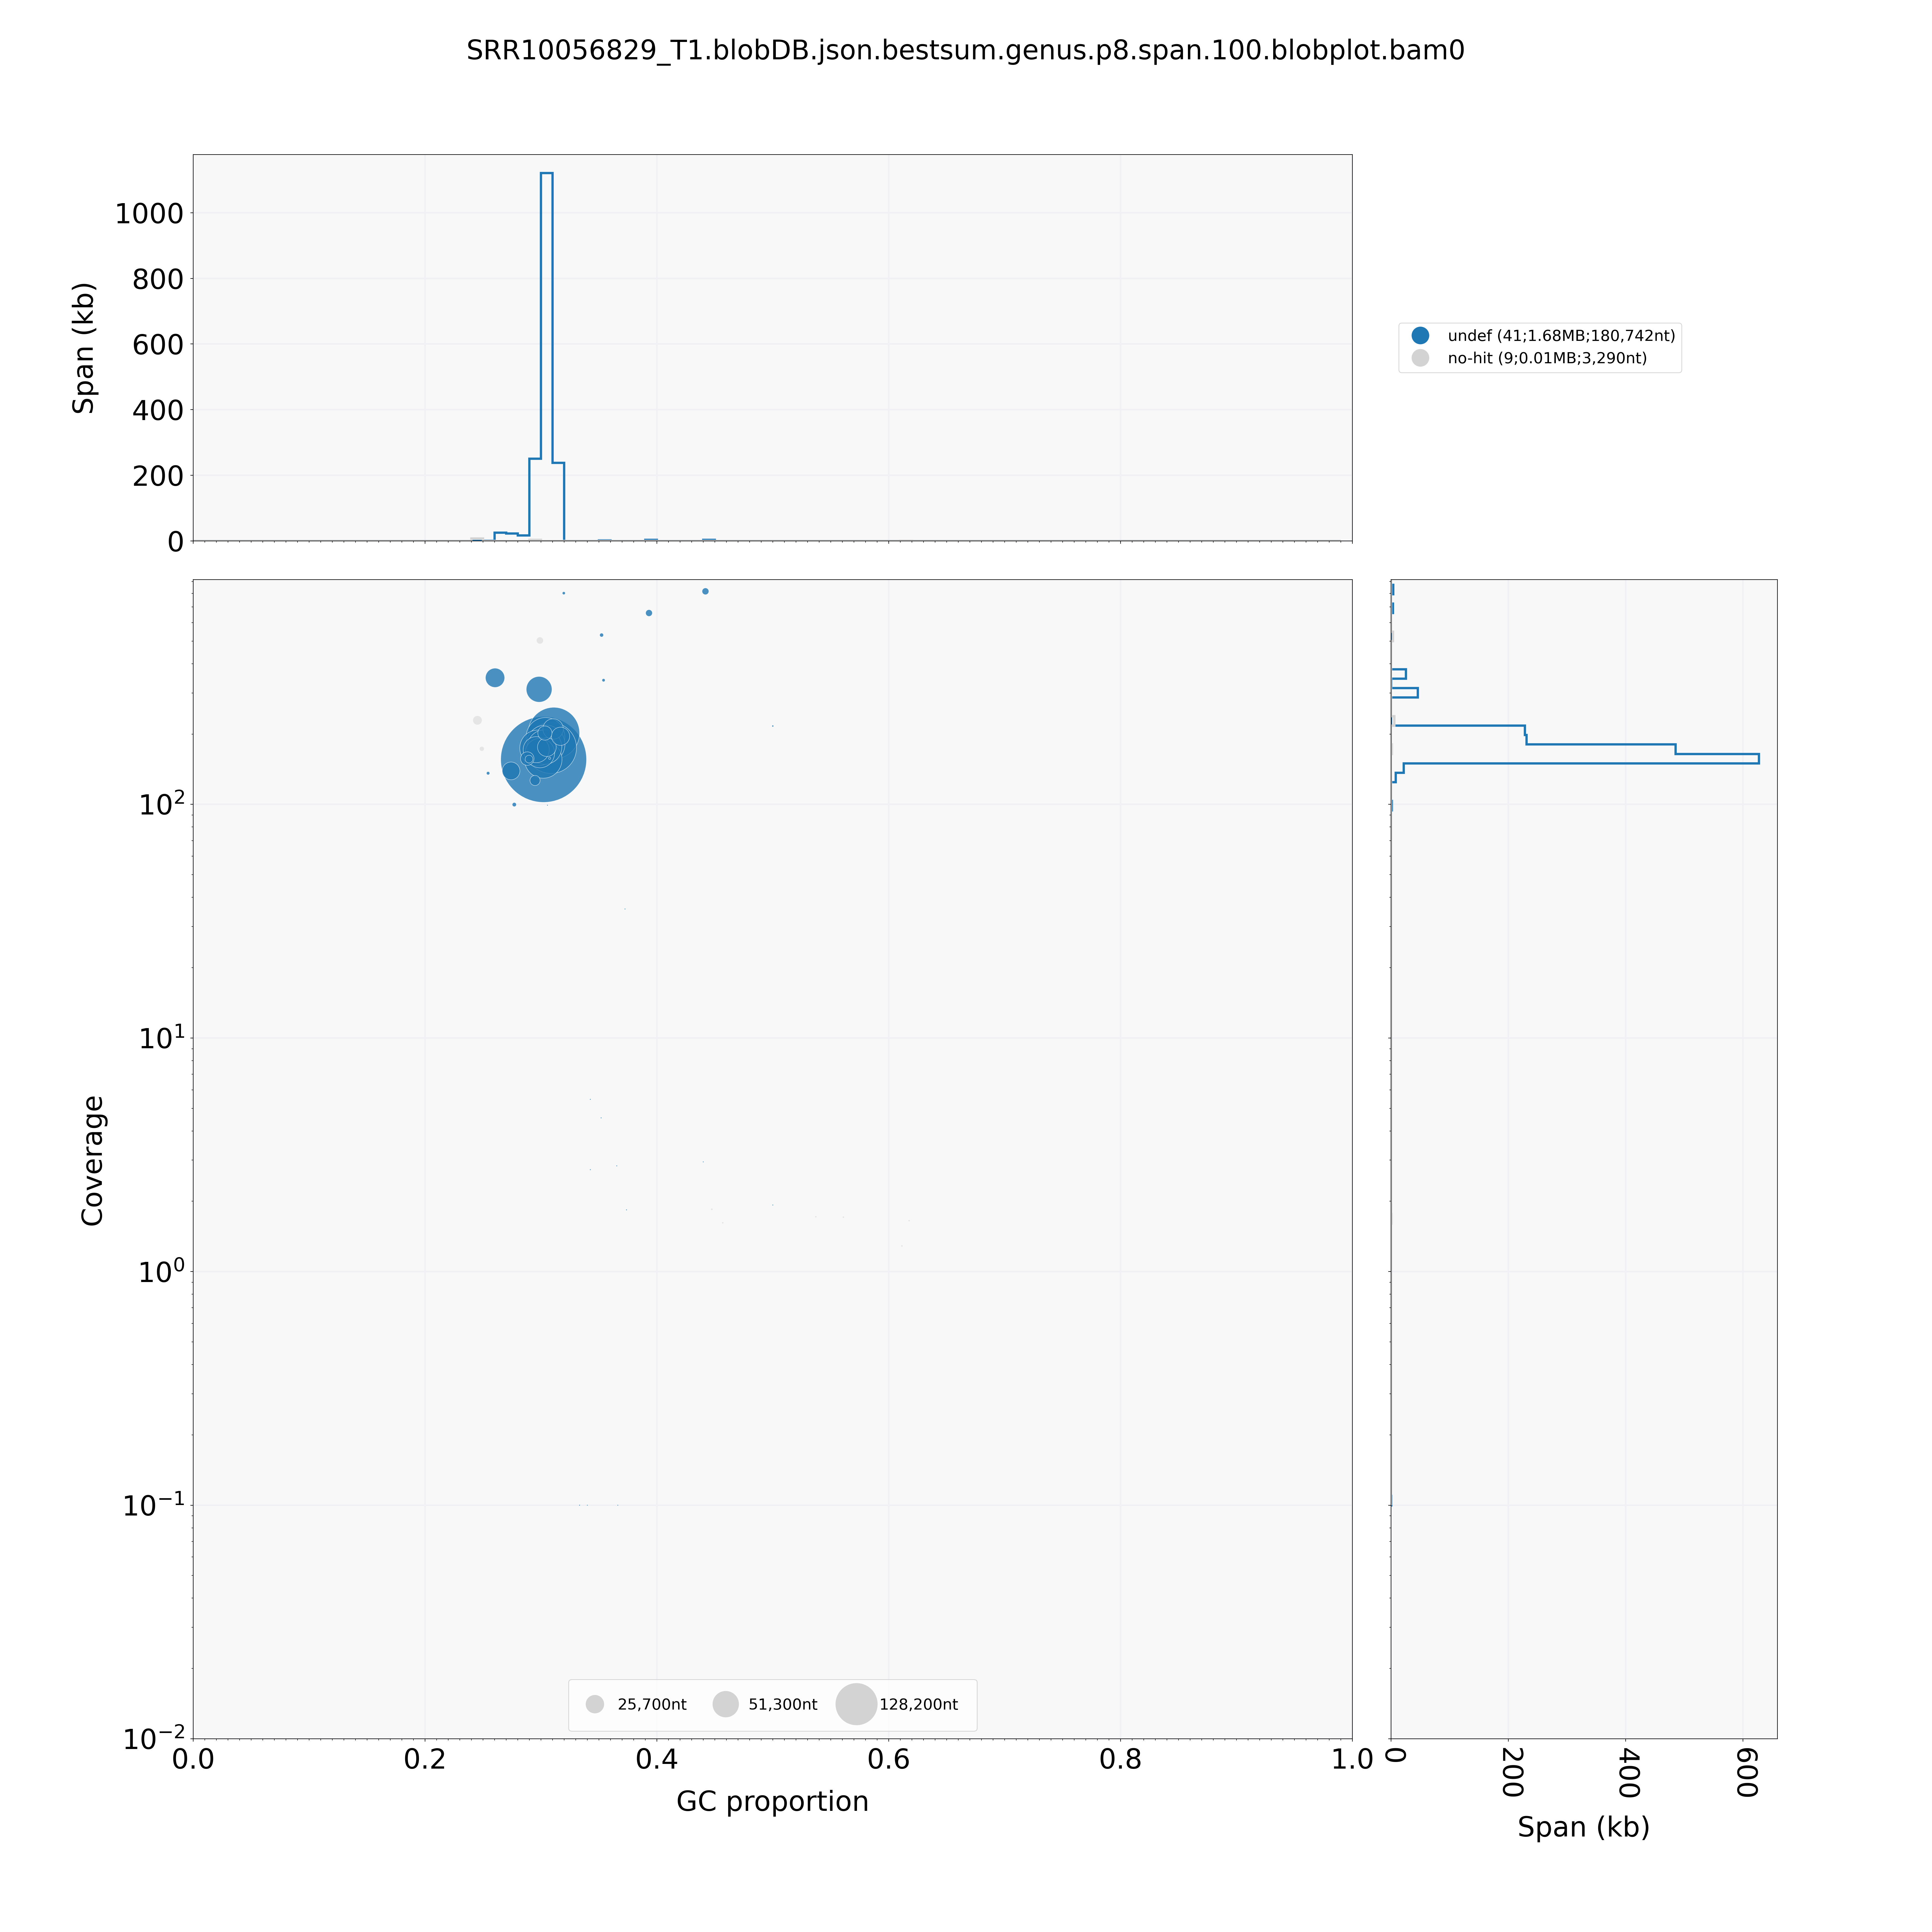

In [10]:
# view blobtools plots
from IPython.display import Image
Image('wgsbac/assets/results/final_results/blobtools_plots/SRR10056829_T1_blobplot.png', width=1000)

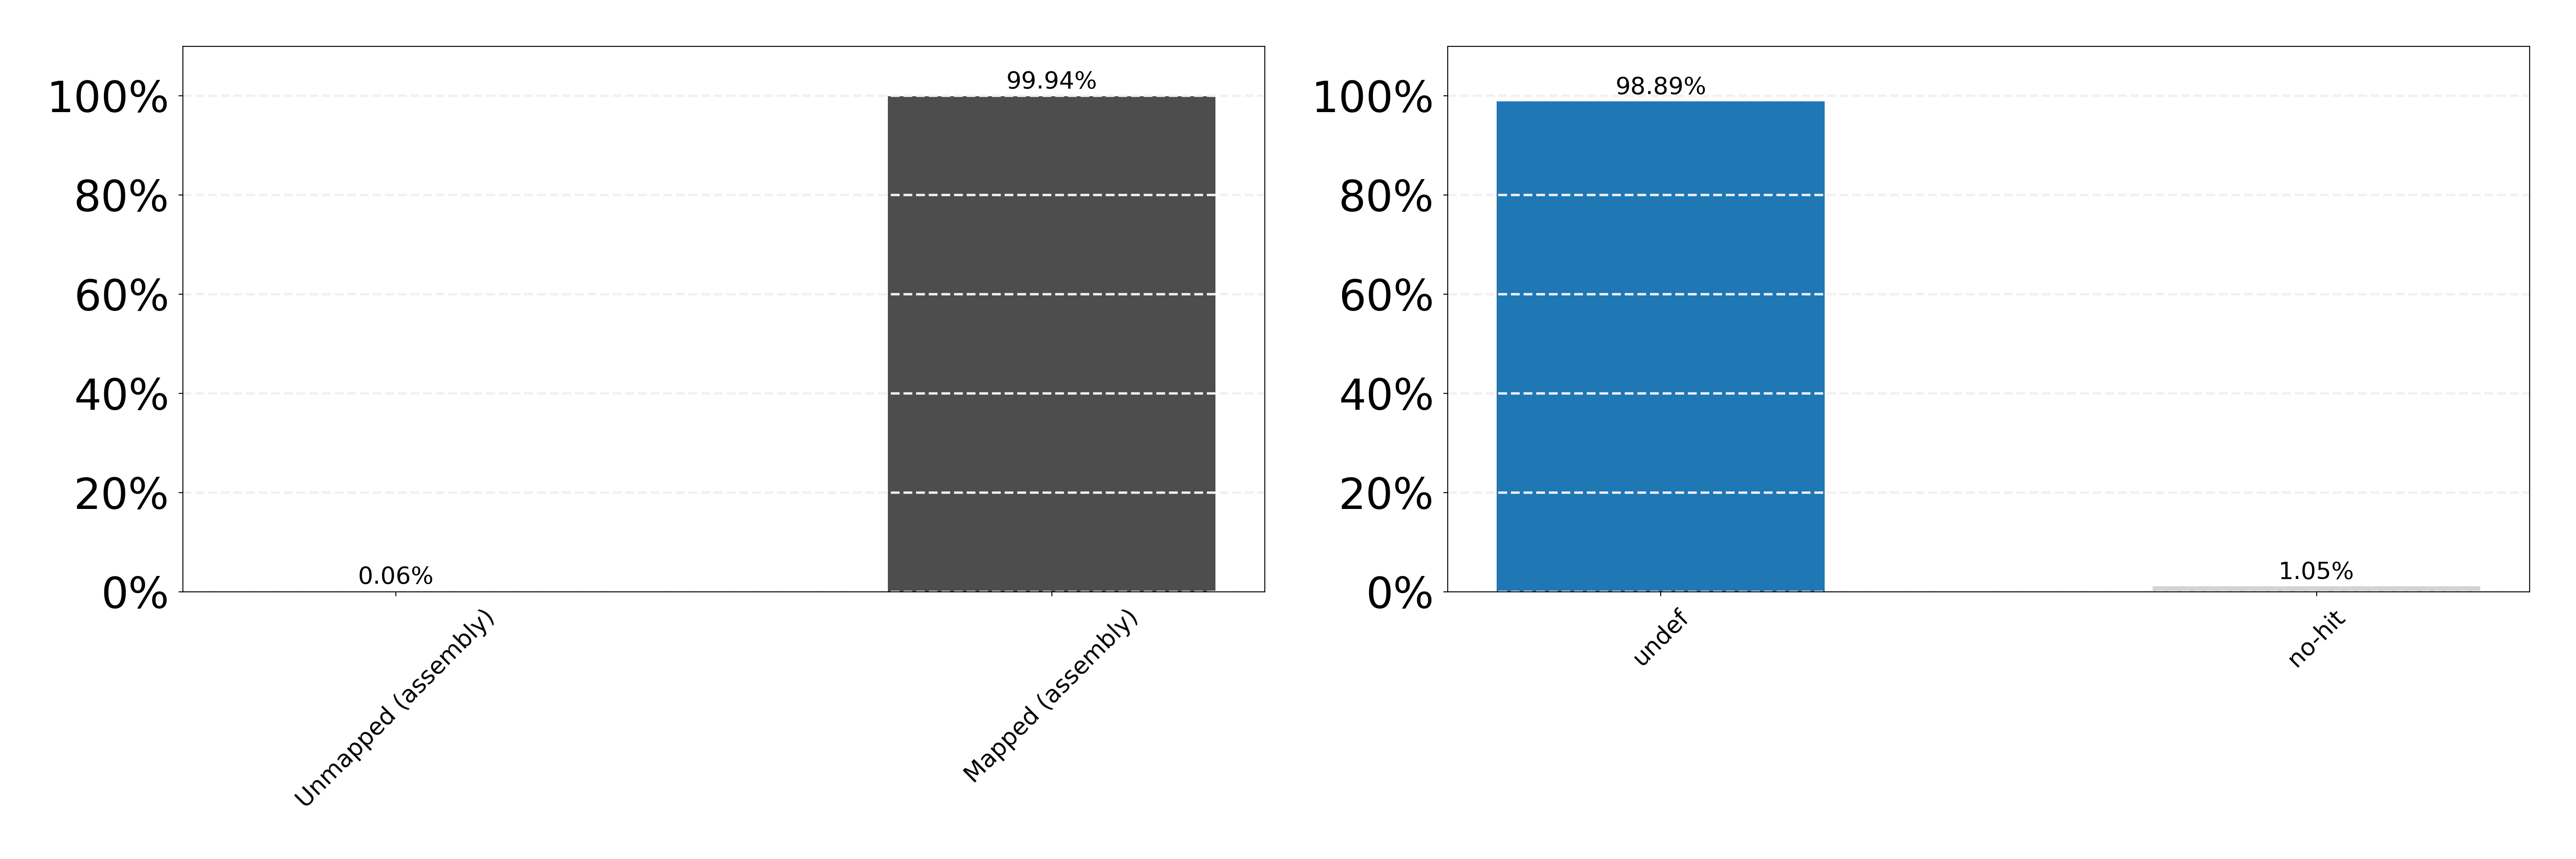

In [11]:
from IPython.display import Image
Image('wgsbac/assets/results/final_results/blobtools_plots/SRR10056829_T1_blobplot_read_cov.png', width=1200)